# EBAC - Regressão II - regressão múltipla

## Tarefa I

#### Previsão de renda II

Vamos continuar trabalhando com a base 'previsao_de_renda.csv', que é a base do seu próximo projeto. Vamos usar os recursos que vimos até aqui nesta base.

|variavel|descrição|
|-|-|
|data_ref                | Data de referência de coleta das variáveis |
|index                   | Código de identificação do cliente|
|sexo                    | Sexo do cliente|
|posse_de_veiculo        | Indica se o cliente possui veículo|
|posse_de_imovel         | Indica se o cliente possui imóvel|
|qtd_filhos              | Quantidade de filhos do cliente|
|tipo_renda              | Tipo de renda do cliente|
|educacao                | Grau de instrução do cliente|
|estado_civil            | Estado civil do cliente|
|tipo_residencia         | Tipo de residência do cliente (própria, alugada etc)|
|idade                   | Idade do cliente|
|tempo_emprego           | Tempo no emprego atual|
|qt_pessoas_residencia   | Quantidade de pessoas que moram na residência|
|renda                   | Renda em reais|

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
data = pd.read_csv('../previsao_de_renda.csv')
data.drop(['Unnamed: 0', 'id_cliente'], axis=1, inplace=True)
data.dropna(inplace=True)
data.head()

,data_ref,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,2015-01-01,F,False,True,0,Empresário,Secundário,Solteiro,Casa,26,6.602740,1.0,8060.34
1,2015-01-01,M,True,True,0,Assalariado,Superior completo,Casado,Casa,28,7.183562,2.0,1852.15
2,2015-01-01,F,True,True,0,Empresário,Superior completo,Casado,Casa,35,0.838356,2.0,2253.89
3,2015-01-01,F,False,True,1,Servidor público,Superior completo,Casado,Casa,30,4.846575,3.0,6600.77
4,2015-01-01,M,True,False,0,Assalariado,Secundário,Solteiro,Governamental,33,4.293151,1.0,6475.97


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12427 entries, 0 to 14999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   data_ref               12427 non-null  object 
 1   sexo                   12427 non-null  object 
 2   posse_de_veiculo       12427 non-null  bool   
 3   posse_de_imovel        12427 non-null  bool   
 4   qtd_filhos             12427 non-null  int64  
 5   tipo_renda             12427 non-null  object 
 6   educacao               12427 non-null  object 
 7   estado_civil           12427 non-null  object 
 8   tipo_residencia        12427 non-null  object 
 9   idade                  12427 non-null  int64  
 10  tempo_emprego          12427 non-null  float64
 11  qt_pessoas_residencia  12427 non-null  float64
 12  renda                  12427 non-null  float64
dtypes: bool(2), float64(3), int64(2), object(6)
memory usage: 1.2+ MB


1. Separe a base em treinamento e teste (25% para teste, 75% para treinamento).
2. Rode uma regularização *ridge* com alpha = [0, 0.001, 0.005, 0.01, 0.05, 0.1] e avalie o $R^2$ na base de testes. Qual o melhor modelo?
3. Faça o mesmo que no passo 2, com uma regressão *LASSO*. Qual método chega a um melhor resultado?
4. Rode um modelo *stepwise*. Avalie o $R^2$ na vase de testes. Qual o melhor resultado?
5. Compare os parâmetros e avalie eventuais diferenças. Qual modelo você acha o melhor de todos?
6. Partindo dos modelos que você ajustou, tente melhorar o $R^2$ na base de testes. Use a criatividade, veja se consegue inserir alguma transformação ou combinação de variáveis.
7. Ajuste uma árvore de regressão e veja se consegue um $R^2$ melhor com ela.

In [4]:
# Exc 1
y = data['renda'].copy()
X = data.drop('renda', axis=1).copy()

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

data_train = pd.concat([x_train, y_train], axis=1)
data_train['log_renda'] = np.log(data_train['renda'])
data_train.head(5)

,data_ref,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,log_renda
5269,2015-06-01,F,False,True,0,Empresário,Secundário,Casado,Casa,40,15.109589,2.0,6014.68,8.701958
4685,2015-05-01,M,True,False,1,Assalariado,Secundário,Casado,Casa,26,0.380822,3.0,1634.01,7.398792
820,2015-01-01,M,True,True,0,Assalariado,Secundário,Casado,Com os pais,44,8.523288,2.0,7692.33,8.947979
4703,2015-05-01,M,False,True,0,Empresário,Superior completo,Solteiro,Aluguel,27,3.345205,1.0,1935.13,7.567930
572,2015-01-01,F,False,False,0,Assalariado,Secundário,Casado,Casa,52,9.030137,2.0,2552.31,7.844754


In [5]:
# Setup for exc 2

def casela_de_ref(col: pd.Series) -> str:
    index = ''
    freq_lst = col.value_counts() / len(col)
    for i, value in enumerate(freq_lst):
        if value == freq_lst.max():
            index = freq_lst.index[i]
    return index
    
def calculate_r2_and_aic(y_true, y_pred, data, model_reg, target_name):
    return calculate_r2(y_true, y_pred), calculate_aic(data, model_reg, target_name)

def calculate_r2(y_true, y_pred):
    y = y_true
    y_hat = y_pred
    mean = np.mean(y_true)
    return 1 - (np.sum((y - y_hat)**2) / np.sum((y - mean)**2))

def calculate_aic(data, model_reg, target_name):
    n = len(data)
    k = len(model_reg.params)
    rss = np.sum((data[target_name] - model_reg.predict(data))**2)
    log_likelihood = -len(data) / 2 * (np.log(2 * np.pi * rss / n) + 1)
    return 2 * k - 2 * log_likelihood

def set_formula(data, target):
    formula = '{} ~ '.format(target)
    
    for col in data:
        if data[col].dtype == 'O':
            formula += "C({}, Treatment(reference='{}')) + ".format(col, casela_de_ref(data[col]))
        else:
            formula += "{} + ".format(col)
    
    return formula[:-3]


    O modelo com alpha = 0 tem:
    R² = -0.472873263710925
    AIC = 20291.929731514603
    

    O modelo com alpha = 0.001 tem:
    R² = -0.47287284944476404
    AIC = 20365.622245938004
    

    O modelo com alpha = 0.005 tem:
    R² = -0.4728722651386019
    AIC = 20641.5018180819
    

    O modelo com alpha = 0.01 tem:
    R² = -0.4728718982078064
    AIC = 21110.673884890894
    

    O modelo com alpha = 0.05 tem:
    R² = -0.47287253226969206
    AIC = 24649.304999843756
    

    O modelo com alpha = 0.1 tem:
    R² = -0.47287542208522826
    AIC = 27033.063794835427
    


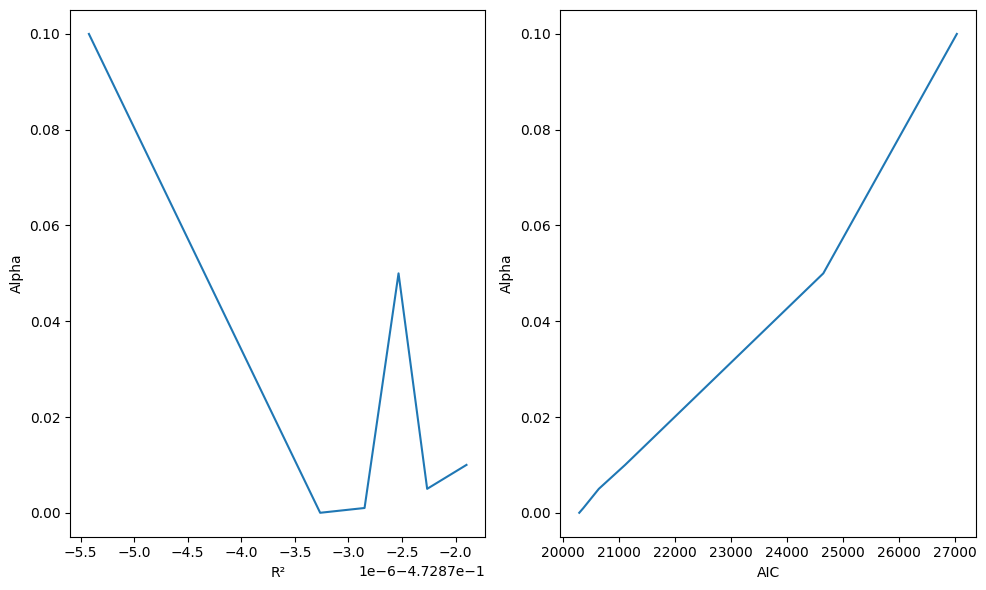

In [6]:
# Exc 2
formula = set_formula(x_train, 'log_renda')
alphas = [0, 0.001, 0.005, 0.01, 0.05, 0.1]
lst_r2 = []
lst_aic = []

for alpha in alphas:
    model = smf.ols(formula, data_train)
    reg = model.fit_regularized(method='elastic_net', refit=True, L1_wt=0, alpha=alpha)

    r2, aic = calculate_r2_and_aic(y_test, reg.predict(x_test), data_train, reg, 'log_renda')
    lst_r2.append(r2)
    lst_aic.append(aic)
        
    print("="*50)
    print("""
    O modelo com alpha = {} tem:
    R² = {}
    AIC = {}
    """.format(alpha, r2, aic))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
sns.lineplot(y=[alpha for alpha in alphas], x=lst_r2, ax=ax[0])
ax[0].set_xlabel('R²')
ax[0].set_ylabel('Alpha')
sns.lineplot(y=[alpha for alpha in alphas], x=lst_aic, ax=ax[1])
ax[1].set_xlabel('AIC')
ax[1].set_ylabel('Alpha')
plt.tight_layout()

Analisando o resultado acima e observando o gráfico criado, é possível notar que a regularização do modelo é **inutilizável** pois, apresenta um valor de R² negativo para todas as instâncias de alpha, com mínimas variações, isso prova que o modelo criado por meio desse método não será capaz de realizar previsões satisfatórias.


    O modelo com alpha = 0 tem:
    R² = -0.472873263710925
    AIC = 20291.929731514603
    

    O modelo com alpha = 0.001 tem:
    R² = -0.4728737298076737
    AIC = 20337.834272610307
    

    O modelo com alpha = 0.005 tem:
    R² = -0.4728749812447268
    AIC = 20507.364176637515
    

    O modelo com alpha = 0.01 tem:
    R² = -0.4728749336801745
    AIC = 20482.60571121064
    

    O modelo com alpha = 0.05 tem:
    R² = -0.4728751526108752
    AIC = 20529.628500590225
    

    O modelo com alpha = 0.1 tem:
    R² = -0.4728751526108752
    AIC = 20529.628500590225
    


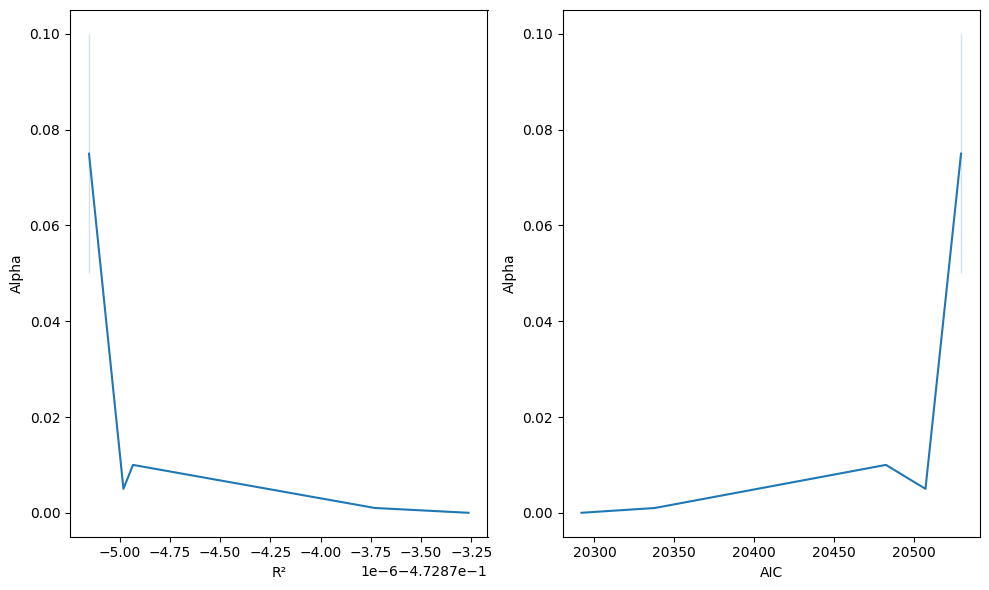

In [7]:
# Exc 3
formula = set_formula(x_train, 'log_renda')
alphas = [0, 0.001, 0.005, 0.01, 0.05, 0.1]
lst_r2 = []
lst_aic = []

for alpha in alphas:
    model = smf.ols(formula, data_train)
    reg = model.fit_regularized(method='elastic_net', refit=True, L1_wt=1, alpha=alpha)

    r2, aic = calculate_r2_and_aic(y_test, reg.predict(x_test), data_train, reg, 'log_renda')
    lst_r2.append(r2)
    lst_aic.append(aic)
        
    print("="*50)
    print("""
    O modelo com alpha = {} tem:
    R² = {}
    AIC = {}
    """.format(alpha, r2, aic))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
sns.lineplot(y=[alpha for alpha in alphas], x=lst_r2, ax=ax[0])
ax[0].set_xlabel('R²')
ax[0].set_ylabel('Alpha')
sns.lineplot(y=[alpha for alpha in alphas], x=lst_aic, ax=ax[1])
ax[1].set_xlabel('AIC')
ax[1].set_ylabel('Alpha')
plt.tight_layout()

O mesmo resultado de antes, mesmo utilizando outra forma de regularização, o modelo criado ainda proporciona um **R²** negativo, o que torna seu uso impróprio para criar previsões.

In [8]:
# Setup exc 4
X['sexo'] = X['sexo'].map({'F': 1, 'M': 0})
dummies = pd.get_dummies(X.loc[:, X.dtypes == 'O'])
X = pd.concat([X.drop(X.loc[:, X.dtypes == 'O'].columns, axis=1), dummies], axis=1)

for col in X.columns:
    if ' ' in col:
        new_col = col.replace(' ', '_')
        X.rename(columns={col: new_col}, inplace=True)

for col in X.loc[:, X.dtypes == bool]:
    X[col] = X[col].map({True: 1, False: 0})

dummies = pd.get_dummies(data_train.loc[:, data_train.dtypes == 'O'])
data_train = pd.concat([data_train.drop(data_train.loc[:, data_train.dtypes == 'O'].columns, axis=1), dummies], axis=1)
data_train['sexo'] = X['sexo']

for col in data_train.columns:
    if ' ' in col:
        new_col = col.replace(' ', '_')
        data_train.rename(columns={col: new_col}, inplace=True)

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.05, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded, dtype=np.dtype('float64'))
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.index[new_pval.argmin()]
            included.append(best_feature)
            changed=True
            if verbose:
                 print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        print("#############")
        print(included)
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included


variables = stepwise_selection(X, y)

Add  tempo_emprego                  with p-value 0.0
#############
['tempo_emprego']
Add  sexo                           with p-value 0.0
#############
['tempo_emprego', 'sexo']
Add  tipo_renda_Empresário          with p-value 1.75299e-07
#############
['tempo_emprego', 'sexo', 'tipo_renda_Empresário']
Add  idade                          with p-value 1.9605e-07
#############
['tempo_emprego', 'sexo', 'tipo_renda_Empresário', 'idade']
Add  educacao_Superior_completo     with p-value 3.07164e-06
#############
['tempo_emprego', 'sexo', 'tipo_renda_Empresário', 'idade', 'educacao_Superior_completo']
Add  estado_civil_Casado            with p-value 0.00727196
#############
['tempo_emprego', 'sexo', 'tipo_renda_Empresário', 'idade', 'educacao_Superior_completo', 'estado_civil_Casado']
Add  posse_de_imovel                with p-value 0.0121024
#############
['tempo_emprego', 'sexo', 'tipo_renda_Empresário', 'idade', 'educacao_Superior_completo', 'estado_civil_Casado', 'posse_de_imovel']
#####

In [9]:
# Exc 4
formula = 'log_renda ~ '

for var in variables:
    formula += '{} + '.format(var)

formula = formula[:-3]
lst_r2 = []
lst_aic = []

for alpha in alphas:
    model = smf.ols(formula, data_train)
    reg = model.fit_regularized(method='elastic_net', refit=True, L1_wt=1, alpha=alpha)

    r2, aic = calculate_r2_and_aic(y_test, reg.predict(x_test), data_train, reg, 'log_renda')
    lst_r2.append(r2)
    lst_aic.append(aic)
        
    print("="*50)
    print("""
    O modelo com alpha = {} tem:
    R² = {}
    AIC = {}
    """.format(alpha, r2, aic))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
sns.lineplot(y=[alpha for alpha in alphas], x=lst_r2, ax=ax[0])
ax[0].set_xlabel('R²')
ax[0].set_ylabel('Alpha')
sns.lineplot(y=[alpha for alpha in alphas], x=lst_aic, ax=ax[1])
ax[1].set_xlabel('AIC')
ax[1].set_ylabel('Alpha')
plt.tight_layout()

AttributeError: predict requires that you use a DataFrame when predicting from a model
that was created using the formula api.

The original error message returned by patsy is:
'DataFrame' object has no attribute 'dtype'